# Annual Sea Level Anomalies
Annual mean sea level anomalies. This page is very much in development!!

```{caution}
Major updates are needed for this page. Don't look at it too hard...
```


## Setup

As with previous sections, we first need to import the necessary libraries, establish our input/output directories, and set up some basic plotting rules. We'll do this by running another notebook called "setup" and "plotting functions," and then we'll set our data and output paths. If you have not run the datawrangling notebook, you will need to do this before running this notebook.

In [1]:
%run ../setup.ipynb
%run ../plotting_functions.ipynb
data_dir = Path('../../data' )
output_dir = Path('../../output') 

# check to make sure that data_dir/rsl_daily_hawaii.nc exists, if not, make warning to run datawrangling notebook
if not (data_dir / 'rsl_daily_hawaii.nc').exists():
    print('rsl_daily_hawaii.nc not found in ../../data. Please run the data wrangling notebook first')
else:
    print('rsl_daily_hawaii.nc found in ../../data. Proceed.')



rsl_daily_hawaii.nc found in ../../data. Proceed.


```{margin}
```{note}
**TODO**

-Trend dates?
-Confirm numbers match
-Figure captions
-Figure labels
-Text
-Check with John's master plan

```
```

### Import the tide gauge data

In [2]:
#import rsl_daily
rsl_daily = xr.open_dataset(data_dir/ 'rsl_daily_hawaii.nc')

#make rsl_daily a subset - do not include TGs with more than 25% NaNs
# get percent Nans in rsl_daily['sea_level']

rsl_daily

<xarray.Dataset>
Dimensions:       (record_id: 11, time: 10957)
Coordinates:
  * record_id     (record_id) int16 140 500 520 570 580 ... 610 5470 5480 5520
  * time          (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2022-12-31
    lat           (record_id) float32 ...
    lon           (record_id) float32 ...
    station_name  (record_id) <U17 ...
    storm_time    (time) datetime64[ns] ...
Data variables:
    rsl_anomaly   (record_id, time) float32 ...
    rsl_mhhw      (record_id, time) float64 ...
Attributes:
    long_name:  Sea Level Anomaly
    units:      m
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...
    epoch:      1993-2001

### Do some data wrangling again. 
#### 1. Check the data and drop all stations with less than 80% coverage

In [3]:
data_coverage = rsl_daily.rsl_mhhw.count(dim='time')/len(rsl_daily.time)

#drop all locations with data_coverage less than 80%
rsl_subset = rsl_daily.where(data_coverage>0.80,drop=True)

rsl_subset

<xarray.Dataset>
Dimensions:       (record_id: 8, time: 10957)
Coordinates:
  * record_id     (record_id) int16 500 520 570 580 590 600 610 5520
  * time          (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2022-12-31
    lat           (record_id) float32 28.22 16.75 21.31 ... 19.73 21.43 20.03
    lon           (record_id) float32 182.6 190.5 202.1 ... 204.9 202.2 204.2
    station_name  (record_id) <U17 'Midway' 'Johnston' ... 'Mokuoloe' 'Kawaihae'
    storm_time    (time) datetime64[ns] ...
Data variables:
    rsl_anomaly   (record_id, time) float32 -0.05425 -0.022 ... -0.1367
    rsl_mhhw      (record_id, time) float64 -0.2078 -0.1756 ... -0.3183 -0.446
Attributes:
    long_name:  Sea Level Anomaly
    units:      m
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...
    epoch:      1993-2001

#### 2. Now we'll remove the trend (over the entire record) from this subset of stations.

In [4]:
trend_mag, sea_level_trend, trend_rate = process_trend_with_nan(rsl_subset['rsl_anomaly'])

rsl_subset['rsl_anomaly_detrended'] = rsl_subset['rsl_anomaly'] - sea_level_trend

#### 3. Resample to monthly time series of anomalies.

In [5]:
# resample to monthly time series 
rsl_monthly = rsl_subset.resample(time='1ME',label='right').mean()

# get climatology (annual cycle) by grouping by month
rsl_climatology = rsl_monthly.groupby('time.month').mean('time')

# get anomalies by subtracting climatology from monthly data
rsl_anomalies = rsl_monthly.groupby('time.month') - rsl_climatology

rsl_anomalies

ValueError: Invalid frequency: 1ME

#### 4. Now sort the subset on "storm year" instead of calendar year for yearly means.

In [20]:
# change the index to be on storm_time instead of time
rsl_subset = rsl_subset.set_index(time='storm_time')

# rename the time dimension to storm_time
rsl_subset = rsl_subset.rename({'time':'storm_time'})

rsl_subset

<xarray.Dataset> Size: 1MB
Dimensions:                (record_id: 8, storm_time: 10957)
Coordinates:
  * record_id              (record_id) int16 16B 500 520 570 ... 600 610 5520
  * storm_time             (storm_time) datetime64[ns] 88kB 1992-01-01 ... 20...
    lat                    (record_id) float32 32B 28.22 16.75 ... 21.43 20.03
    lon                    (record_id) float32 32B 182.6 190.5 ... 202.2 204.2
    station_name           (record_id) <U17 544B 'Midway' ... 'Kawaihae'
Data variables:
    rsl_anomaly            (record_id, storm_time) float32 351kB -0.05425 ......
    rsl_mhhw               (record_id, storm_time) float64 701kB -0.2078 ... ...
    rsl_anomaly_detrended  (record_id, storm_time) float32 351kB -0.01937 ......
Attributes:
    long_name:  Sea Level Anomaly
    units:      m
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...
    epoch:      1993-2001

In [21]:
# reorder to that storm_time is monotonicly increasing
rsl_subset = rsl_subset.sortby('storm_time')

# Group by storm_year and record_id
rsl_yearly_mean = rsl_subset.groupby('storm_time.year').mean('storm_time')

# give year dimension a name
rsl_yearly_mean = rsl_yearly_mean.rename({'year':'storm_year'})

rsl_yearly_mean

<xarray.Dataset> Size: 5kB
Dimensions:                (storm_year: 31, record_id: 8)
Coordinates:
  * record_id              (record_id) int16 16B 500 520 570 ... 600 610 5520
    lat                    (record_id) float32 32B 28.22 16.75 ... 21.43 20.03
    lon                    (record_id) float32 32B 182.6 190.5 ... 202.2 204.2
    station_name           (record_id) <U17 544B 'Midway' ... 'Kawaihae'
  * storm_year             (storm_year) int64 248B 1992 1993 1994 ... 2021 2022
Data variables:
    rsl_anomaly            (storm_year, record_id) float32 992B -0.05539 ... ...
    rsl_mhhw               (storm_year, record_id) float64 2kB -0.209 ... -0....
    rsl_anomaly_detrended  (storm_year, record_id) float32 992B -0.02112 ... ...
Attributes:
    long_name:  Sea Level Anomaly
    units:      m
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...
    epoch:      1993-2001

## Absolute Value: satellite (trend removed)

In [27]:
# open the cmems data
cmems = xr.open_dataset(data_dir / 'cmems_L4_SSH_0.25deg_1993_2023.nc')

### Plot an area-wide map, with stations
First we'll need to make sure that our data is detrended properly in order to look at yearly anomalies.

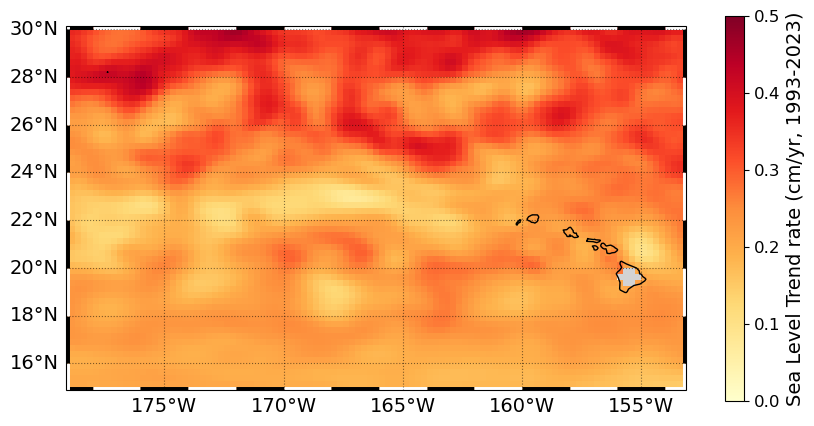

In [111]:
# concentrating on decadal trends
# let's look at 1993-2003 and 2003-2013

trend_mag, sea_level_trend, trend_rate = process_trend_with_nan(cmems['sla'].sel(time=slice('1993','2023')),weighted=False)

# define vmin and vmax variables
vmin = 0
vmax = 0.5
xlims = [cmems.longitude.min(), cmems.longitude.max()]
ylims = [cmems.latitude.min(), cmems.latitude.max()]

trend_rate_cm = trend_rate * 100 # convert to cm/yr

# make ax,fig
crs = ccrs.PlateCarree()
cmap = 'YlOrRd'
fig, ax, crs = plot_map(vmin,vmax,cmap,xlims,ylims)
trend_rate_cm.plot(ax=ax, transform=crs,
                         vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=True, 
                         cbar_kwargs={'label': 'Sea Level Trend rate (cm/yr, 1993-2023)'}
)

# Call the function to add the zebra frame
plot_zebra_frame(ax, lw=5, segment_length=2, crs=crs)


### Area-weighted average trend 
Is this something we want to do for the region? I don't think so? I suppose we'll use the entire grid for this? For example:

In [95]:
startYear = '1993'
endYear = '2023'
trend_mag, sea_level_trend, trend_rate = process_trend_with_nan(cmems['sla'].sel(time=slice(startYear,endYear)),weighted=True)

print(f'The trend rate for {startYear}-{endYear} in the entire grid is {trend_rate*100:.2f} cm/yr')


The trend rate for 1993-2023 in the entire grid is 0.22 cm/yr


In [96]:
# concentrating on decadal trends
# let's look at 1993-2003 and 2003-2013
cmems1993_2003 = cmems.sel(time=slice('1993','2003'))

# get the overall trend (full time series)
trend_mag, sea_level_trend, trend_rate = process_trend_with_nan(cmems['sla'])
trend_mag_area_weighted, sea_level_trend_area_weighted, trend_rate_area_weighted = process_trend_with_nan(cmems['sla'],weighted=True)


#remove the trend from the data
sla_detrended = cmems1993_2003['sla'] - sea_level_trend.sel(time=slice('1993','2003'))
sla_detrended_area_weighted = cmems1993_2003['sla'] - sea_level_trend_area_weighted.sel(time=slice('1993','2003'))

Text(0.5, 1.0, 'Midway')

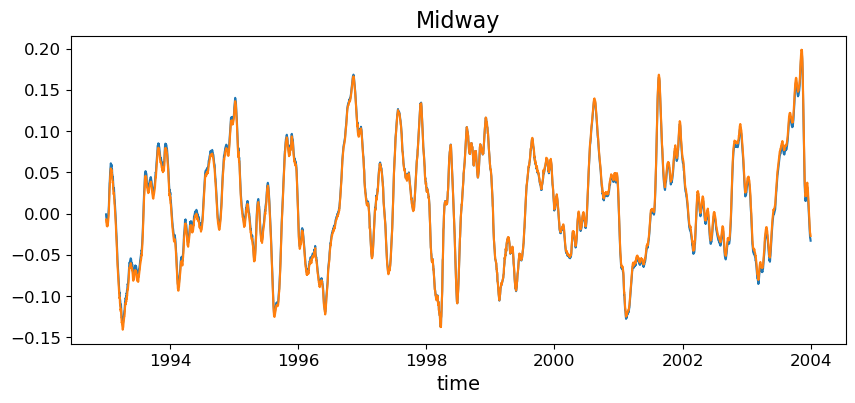

In [97]:
lat = rsl_subset.isel(record_id=rid).lat
lon = rsl_subset.isel(record_id=rid).lon
sla_detrended.sel(latitude=lat, longitude=lon, method='nearest').plot(label='Sea Level Anomaly (m)')
sla_detrended_area_weighted.sel(latitude=lat, longitude=lon, method='nearest').plot(label='Area Weighted Sea Level Anomaly (m)')

# change the title to station name
plt.title(rsl_subset['station_name'].isel(record_id=rid).values)

There are slight differences between removing the grid-level trend versus the area-weighted trend in this plot. But when we get to the full spatial plot, that's where things get weird.

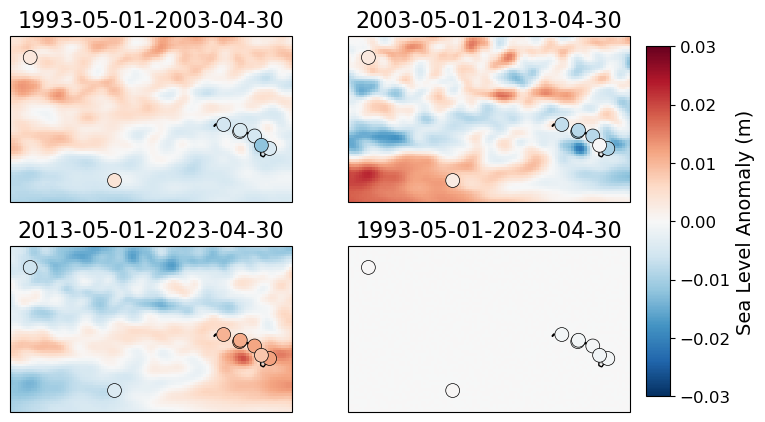

In [105]:
# concentrating on decadal trends
# let's look at 1993-2003 and 2003-2013

yr_start = [1993,2003,2013,1993]
yr_stop = [2003,2013,2023,2023]

#do storm year instead of calendar year

yr_start = [str(int(yr))+'-05-01' for yr in yr_start]
yr_stop = [str(int(yr))+'-04-30' for yr in yr_stop]

trend_mag_weighted, sea_level_trend_weighted, trend_rate_weighted = process_trend_with_nan(cmems['sla'].sel(time=slice(yr_start[0],yr_stop[-1])),weighted=False)

#remove the trend from the data
sla_detrended = cmems['sla'] - sea_level_trend_weighted


# make 3 subplots for each year range
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(2,2,figsize=(8, 5), subplot_kw={'projection': crs})

# Variable to hold the colorbar handle
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # Adjust these values to fit your layout
fig.subplots_adjust(right=0.9)  # Make space for the colorbar
 

vmin = -0.03
vmax = 0.03
# Loop through each period
for i, ax in enumerate(ax.flat):
    # Select the data for the current period and calculate the mean over time
    sla_mean = sla_detrended.sel(time=slice(yr_start[i],yr_stop[i])).mean(dim='time',skipna=True)
    # sla_mean = sla_mean - sea_level_trend.sel(time=slice(str(yr_start[i]), str(yr_stop[i]))).mean(dim='time')

    #subtract the
    
    # Plot the mean sea level anomaly
    c = sla_mean.plot(ax=ax, add_colorbar=False, transform=crs, cmap='RdBu_r')
    
    # Set the title to the current period
    ax.set_title(f'{yr_start[i]}-{yr_stop[i]}')

    # Add coastlines and land  
    palette = sns.color_palette("RdBu_r", as_cmap=True)
    cmap = palette

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, color='lightgrey')
    
    # Optionally, adjust color limits for consistency across plots
    c.set_clim(vmin,vmax)

    ax.scatter(rsl_yearly_mean['lon'], rsl_yearly_mean['lat'], transform=crs, s=50,
              c='white', linewidth=0.5, edgecolor='black',zorder=10)
    
    ax.scatter(rsl_yearly_mean['lon'], rsl_yearly_mean['lat'], transform=crs, s=100, 
           c=rsl_anomalies.sel(time=slice(yr_start[i],yr_stop[i])).rsl_anomaly_detrended.mean(dim="time"), vmin=vmin, vmax=vmax, cmap=cmap,
           linewidth=0.5, edgecolor='black',zorder=10)

# Add the colorbar
cbar = fig.colorbar(c, cax=cbar_ax)
cbar.set_label('Sea Level Anomaly (m)')


glue("SL_YMA_decadal",fig,display=False)



```{glue:figure} SL_YMA_decadal
:name: "SL_YMA_decadal"

Decadal (or bidecadal, is that a word) mean anomalies of the Hawaiian Islands region, background trend (Storm Years 1993-2023) removed. Note that the sea level is plotted in units of m. The mean anomaly is near zero when using the full timeseries and grid-level trends (i.e. no area-weighted averaging). Mean monthly anomalies at the stations are plotted as well, showing similar-ish patterns, with some weirdness at Kawaihae that I should check on.
```

## Relative Value: tide station (trend removed)
### area-wide map with stations
### station plots: time series  
These should have ONI/ENSO phase included on them

In [206]:
def plot_TG_rsl_anomaly_annual(rid, fig, ax, rsl_yearly_mean, rsl_subset, rsl_anomalies,oni, oniPlot=False):

    ax.set_xlim(1993,2022)
    ax.set_ylim(-0.3, 0.5)
    ax.grid(alpha=0.2, color='lightgray')

    if oniPlot:
        ymin, ymax = ax.get_ylim()
        # Shading El Niño events
        ax.fill_between(oni.index, ymin,ymax, 
                        where=oni['El Nino'] == 1, color='blue', alpha=0.1, label='El Niño')
        # Shading La Niña events
        ax.fill_between(oni.index,  ymin,ymax,
                        where=oni['La Nina'] == 1, color='black', alpha=0.1, label='La Niña')
    
    # get min and max for each month
    rsl_yearly_min = rsl_subset.groupby('storm_time.year').min('storm_time')
    rsl_yearly_max = rsl_subset.groupby('storm_time.year').max('storm_time')

    #make a fill from max to min for each month
    ax.fill_between(rsl_yearly_mean.storm_year+0.5, 
                     rsl_yearly_min['rsl_anomaly_detrended'].isel(record_id=rid), 
                     rsl_yearly_max['rsl_anomaly_detrended'].isel(record_id=rid), 
                     alpha=0.2, label='Range (Daily Min-Max)')

    ax.plot(rsl_yearly_mean.storm_year+0.5, 
            rsl_yearly_mean['rsl_anomaly_detrended'].isel(record_id=rid), 
            label='Annual Mean Sea Level Anomaly (m)',alpha=1,linewidth=2)

    # convert rsl_monthly['time'] to float
    storm_time_float = rsl_monthly['time.year'] + (rsl_monthly['time.month']-5)/12 #subtract 5 months to go with 'storm year' convention (May-April)
    ax.plot(storm_time_float, 
            rsl_anomalies['rsl_anomaly_detrended'].isel(record_id=rid), 
            label='Monthly Mean Sea Level Anomaly (m)',alpha=1, color='gray',linewidth=0.75)
    ax.set_ylabel(''), ax.set_xlabel('')

    # add rsl_yearly_mean['station_name'].isel(record_id=rid).values to upper center of plot
    ax.text(0.5, 0.9, rsl_yearly_mean['station_name'].isel(record_id=rid).values, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


First, we'll plot one gauge

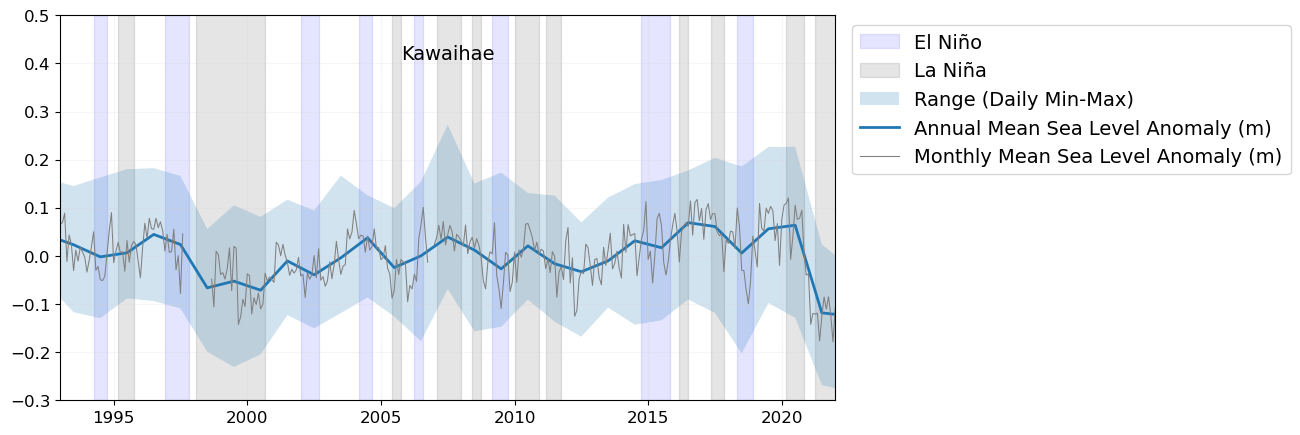

In [209]:
fig,ax = plt.subplots(figsize=(10,5))
# add ENSO to the plots
# import oni.csv
oni = pd.read_csv(data_dir/'oni.csv',header=0)
# change oni index to Date column
oni.index = pd.to_datetime(oni['Date'] )
#adjust the index to be float value of fractional year
oni.index = oni.index.year + (oni.index.month - 1)/12 - 5/12

plot_TG_rsl_anomaly_annual(i, fig, ax,  rsl_yearly_mean, rsl_subset, rsl_anomalies,oni,oniPlot=True)
ax.legend(loc='upper right', ncol=1, bbox_to_anchor=(1.6, 1.0))

# Save the plot to a file
filename = 'SL_MMA_annual_' + str(rsl_yearly_mean['station_name'].isel(record_id=i).values) + '.png'
plt.savefig(output_dir / filename, dpi=300, bbox_inches='tight')

glue('SL_MMA_annual_station',fig,display=False)
station = str(rsl_yearly_mean['station_name'].isel(record_id=i).values)

glue('station',station,display=False)

```{glue:figure} SL_MMA_annual_station
:name: "SL_MMA_annual_station"

Yearly mean anomalies at the {glue:text}`station` tide gauge with background trend removed (blue). The shaded region denotes the yearly means of the daily min and max sea level. Note that the sea level is plotted in units of m. The monthly mean anomaly (orange) is calculated with respect to the annual cycle. El Nino and La Nino time periods are derived from the Oceanic Niño Index (ONI), available at https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php  
```

Now we will plots all the gauges.

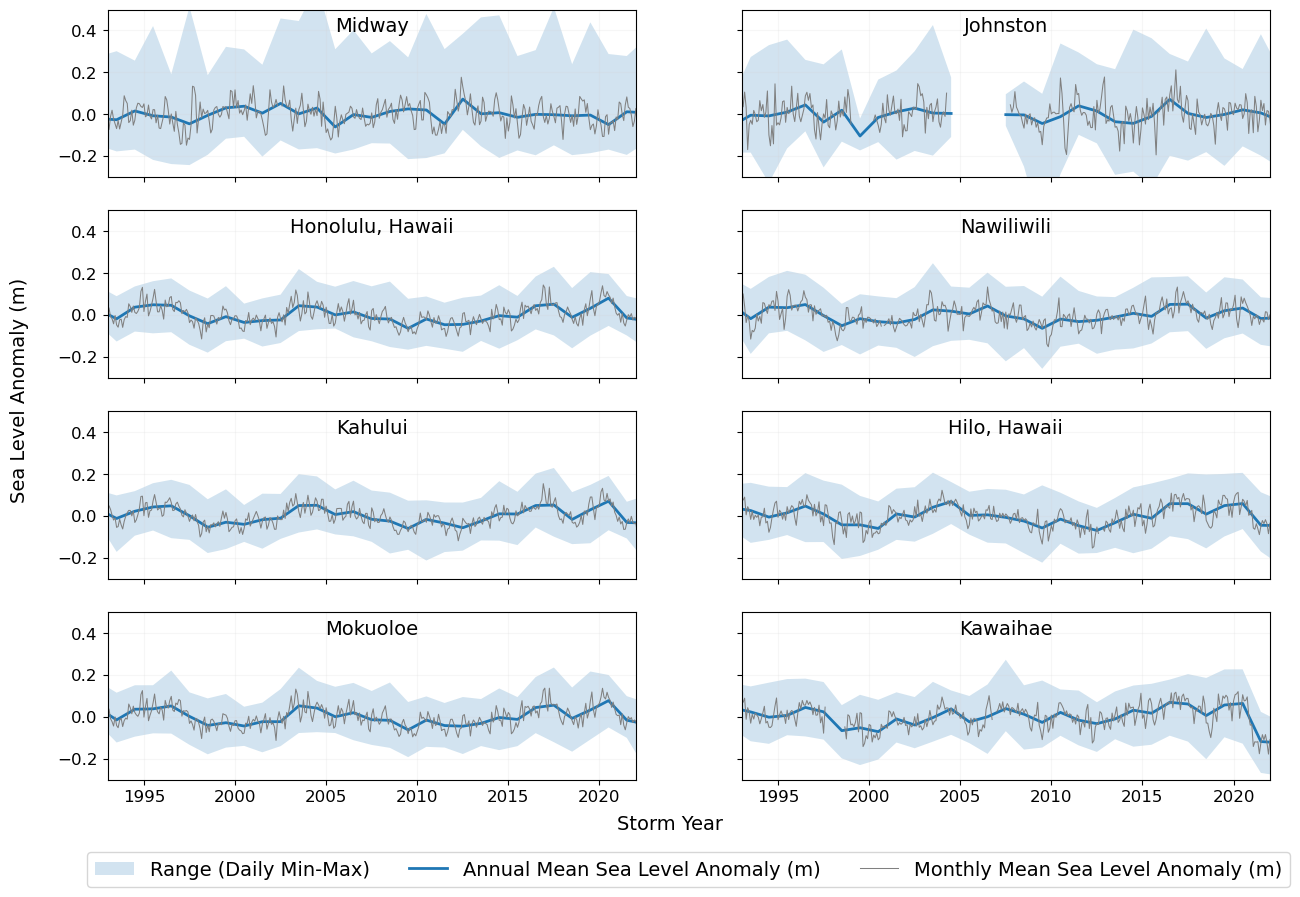

In [210]:
# get axis for the plots
fig,axes = plt.subplots(4,2,figsize=(15,10), sharex=True, sharey=True)
axes = axes.flatten()



record_ids = rsl_monthly.record_id.values
# iterate over each axis and plot the monthly mean
for i in range(len(record_ids)):
    ax = axes[i]
    plot_TG_rsl_anomaly_annual(i, fig, ax,  rsl_yearly_mean, rsl_subset, rsl_anomalies,oni,oniPlot=False)

    if i < 7:
        ax.set_xlabel('')    


#add El Nino and La Nina years


axes[7].legend(loc='lower center', ncol=3,bbox_to_anchor=(-0.1, -0.7))

# add y label
fig.text(0.06, 0.5, 'Sea Level Anomaly (m)', va='center', rotation='vertical')
fig.text(0.5, 0.06, 'Storm Year', ha='center')


# Save the plot to a file
plt.savefig(output_dir / 'SL_MMA_annual.png', dpi=300, bbox_inches='tight')

glue("SL_MMA_annual",fig,display=False)



```{glue:figure} SL_MMA_annual
:name: "SL_MMA_annual"

Yearly mean anomalies at the each tide gauge with background trend removed (blue). The shaded region denotes the yearly means of the daily min and max sea level. Note that the sea level is plotted in units of m. The monthly mean anomaly (orange) is calculated with respect to the annual cycle. This plot is foul looking, it reminds me of a wound, and I will return to it later.
```

## Make a plot

Which plot? Why did I write this.